# ResEmoteNetCNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
    
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
    
class ResEmoteNet(nn.Module):
    def __init__(self):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(256)
        
        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256, 7)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.se(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

# Training with ResEmoteNetCNN Model

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load datasets
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/train',
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root='/kaggle/input/fer2013/test',  
    transform=test_transform
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Initialize model, criterion, and optimizer
model = ResEmoteNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Training parameters
num_epochs = 80
patience = 15
best_val_acc = 0
patience_counter = 0
epoch_counter = 0

# History tracking
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{train_loss/train_total:.4f}',
            'acc': f'{100.*train_correct/train_total:.2f}%'
        })
    
    train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    
    # Update learning rate
    scheduler.step(val_acc)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'\nEpoch {epoch+1}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
        }, 'ResEmoteNetCNN_model.pth')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs.')
        
    if patience_counter >= patience:
        print('Early stopping triggered.')
        break
    
    epoch_counter += 1

# Save final results
num_epochs_completed = len(history['train_loss'])  # Menggunakan panjang aktual dari history
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_completed + 1),
    'Train Loss': history['train_loss'],
    'Val Loss': history['val_loss'],
    'Train Acc': history['train_acc'],
    'Val Acc': history['val_acc']
})
results_df.to_csv('training_history.csv', index=False)

Using cuda device


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training set size: 28709
Validation set size: 7178


Validation: 100%|██████████| 449/449 [00:14<00:00, 30.46it/s]



Epoch 1:
Train Loss: 1.7398, Train Acc: 0.2889
Val Loss: 1.5665, Val Acc: 0.4051


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.34it/s]



Epoch 2:
Train Loss: 1.5448, Train Acc: 0.3981
Val Loss: 1.4148, Val Acc: 0.4480


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.72it/s]



Epoch 3:
Train Loss: 1.4488, Train Acc: 0.4409
Val Loss: 1.3345, Val Acc: 0.4862


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.97it/s]



Epoch 4:
Train Loss: 1.3804, Train Acc: 0.4725
Val Loss: 1.2766, Val Acc: 0.5084


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.32it/s]



Epoch 5:
Train Loss: 1.3247, Train Acc: 0.4981
Val Loss: 1.2289, Val Acc: 0.5284


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.74it/s]



Epoch 6:
Train Loss: 1.2784, Train Acc: 0.5188
Val Loss: 1.1759, Val Acc: 0.5502


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.01it/s]



Epoch 7:
Train Loss: 1.2409, Train Acc: 0.5347
Val Loss: 1.1777, Val Acc: 0.5443
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 74.06it/s]



Epoch 8:
Train Loss: 1.2095, Train Acc: 0.5476
Val Loss: 1.1448, Val Acc: 0.5623


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.97it/s]



Epoch 9:
Train Loss: 1.1763, Train Acc: 0.5630
Val Loss: 1.1345, Val Acc: 0.5690


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.92it/s]



Epoch 10:
Train Loss: 1.1394, Train Acc: 0.5793
Val Loss: 1.1183, Val Acc: 0.5740


Validation: 100%|██████████| 449/449 [00:06<00:00, 71.63it/s]



Epoch 11:
Train Loss: 1.1124, Train Acc: 0.5856
Val Loss: 1.1139, Val Acc: 0.5809


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.29it/s]



Epoch 12:
Train Loss: 1.0832, Train Acc: 0.5948
Val Loss: 1.1093, Val Acc: 0.5790
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.54it/s]



Epoch 13:
Train Loss: 1.0584, Train Acc: 0.6062
Val Loss: 1.0868, Val Acc: 0.5892


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.79it/s]



Epoch 14:
Train Loss: 1.0310, Train Acc: 0.6178
Val Loss: 1.0643, Val Acc: 0.6030


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.22it/s]



Epoch 15:
Train Loss: 1.0071, Train Acc: 0.6293
Val Loss: 1.0748, Val Acc: 0.6016
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.78it/s]



Epoch 16:
Train Loss: 0.9794, Train Acc: 0.6409
Val Loss: 1.0799, Val Acc: 0.6077


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.77it/s]



Epoch 17:
Train Loss: 0.9604, Train Acc: 0.6495
Val Loss: 1.0705, Val Acc: 0.6060
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.83it/s]



Epoch 18:
Train Loss: 0.9277, Train Acc: 0.6600
Val Loss: 1.0828, Val Acc: 0.6024
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.80it/s]



Epoch 19:
Train Loss: 0.9044, Train Acc: 0.6654
Val Loss: 1.0801, Val Acc: 0.6080


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.04it/s]



Epoch 20:
Train Loss: 0.8857, Train Acc: 0.6784
Val Loss: 1.1052, Val Acc: 0.6084


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.23it/s]



Epoch 21:
Train Loss: 0.8556, Train Acc: 0.6843
Val Loss: 1.0792, Val Acc: 0.6105


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.14it/s]



Epoch 22:
Train Loss: 0.8320, Train Acc: 0.6993
Val Loss: 1.1194, Val Acc: 0.6103
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.41it/s]



Epoch 23:
Train Loss: 0.8134, Train Acc: 0.7059
Val Loss: 1.1215, Val Acc: 0.6071
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.38it/s]



Epoch 24:
Train Loss: 0.7905, Train Acc: 0.7158
Val Loss: 1.1075, Val Acc: 0.6116


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.93it/s]



Epoch 25:
Train Loss: 0.7667, Train Acc: 0.7218
Val Loss: 1.0999, Val Acc: 0.6236


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.82it/s]



Epoch 26:
Train Loss: 0.7443, Train Acc: 0.7311
Val Loss: 1.1218, Val Acc: 0.6152
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 72.66it/s]



Epoch 27:
Train Loss: 0.7282, Train Acc: 0.7375
Val Loss: 1.1905, Val Acc: 0.6078
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.74it/s]



Epoch 28:
Train Loss: 0.6986, Train Acc: 0.7507
Val Loss: 1.1354, Val Acc: 0.6147
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 83.78it/s]



Epoch 29:
Train Loss: 0.6820, Train Acc: 0.7561
Val Loss: 1.1671, Val Acc: 0.6213
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 74.48it/s]



Epoch 30:
Train Loss: 0.6563, Train Acc: 0.7655
Val Loss: 1.1494, Val Acc: 0.6232
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.94it/s]



Epoch 31:
Train Loss: 0.6435, Train Acc: 0.7701
Val Loss: 1.1458, Val Acc: 0.6305


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.88it/s]



Epoch 32:
Train Loss: 0.6149, Train Acc: 0.7809
Val Loss: 1.2271, Val Acc: 0.6269
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.49it/s]



Epoch 33:
Train Loss: 0.5949, Train Acc: 0.7894
Val Loss: 1.2161, Val Acc: 0.6259
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.94it/s]



Epoch 34:
Train Loss: 0.5804, Train Acc: 0.7950
Val Loss: 1.2413, Val Acc: 0.6216
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 83.21it/s]



Epoch 35:
Train Loss: 0.5599, Train Acc: 0.7988
Val Loss: 1.2464, Val Acc: 0.6212
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.72it/s]



Epoch 36:
Train Loss: 0.5288, Train Acc: 0.8123
Val Loss: 1.2786, Val Acc: 0.6300
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 74.69it/s]



Epoch 37:
Train Loss: 0.5322, Train Acc: 0.8119
Val Loss: 1.2532, Val Acc: 0.6264
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.03it/s]



Epoch 38:
Train Loss: 0.3873, Train Acc: 0.8666
Val Loss: 1.2890, Val Acc: 0.6442


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.85it/s]



Epoch 39:
Train Loss: 0.3311, Train Acc: 0.8844
Val Loss: 1.3475, Val Acc: 0.6443


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.04it/s]



Epoch 40:
Train Loss: 0.3055, Train Acc: 0.8951
Val Loss: 1.3769, Val Acc: 0.6413
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.02it/s]



Epoch 41:
Train Loss: 0.2878, Train Acc: 0.8999
Val Loss: 1.4342, Val Acc: 0.6453


Validation: 100%|██████████| 449/449 [00:05<00:00, 80.97it/s]



Epoch 42:
Train Loss: 0.2716, Train Acc: 0.9051
Val Loss: 1.4580, Val Acc: 0.6414
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.49it/s]



Epoch 43:
Train Loss: 0.2582, Train Acc: 0.9107
Val Loss: 1.5126, Val Acc: 0.6415
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.70it/s]



Epoch 44:
Train Loss: 0.2470, Train Acc: 0.9141
Val Loss: 1.5194, Val Acc: 0.6400
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.41it/s]



Epoch 45:
Train Loss: 0.2380, Train Acc: 0.9172
Val Loss: 1.5511, Val Acc: 0.6431
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.58it/s]



Epoch 46:
Train Loss: 0.2276, Train Acc: 0.9226
Val Loss: 1.5608, Val Acc: 0.6453
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.63it/s]



Epoch 47:
Train Loss: 0.2177, Train Acc: 0.9251
Val Loss: 1.6078, Val Acc: 0.6449
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.35it/s]



Epoch 48:
Train Loss: 0.2028, Train Acc: 0.9300
Val Loss: 1.5827, Val Acc: 0.6482


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.77it/s]



Epoch 49:
Train Loss: 0.1972, Train Acc: 0.9326
Val Loss: 1.6184, Val Acc: 0.6505


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.62it/s]



Epoch 50:
Train Loss: 0.1929, Train Acc: 0.9332
Val Loss: 1.6046, Val Acc: 0.6500
No improvement for 1 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.22it/s]



Epoch 51:
Train Loss: 0.1881, Train Acc: 0.9350
Val Loss: 1.5928, Val Acc: 0.6477
No improvement for 2 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.63it/s]



Epoch 52:
Train Loss: 0.1901, Train Acc: 0.9351
Val Loss: 1.5777, Val Acc: 0.6460
No improvement for 3 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.91it/s]



Epoch 53:
Train Loss: 0.1911, Train Acc: 0.9334
Val Loss: 1.6475, Val Acc: 0.6467
No improvement for 4 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.27it/s]



Epoch 54:
Train Loss: 0.1877, Train Acc: 0.9356
Val Loss: 1.6323, Val Acc: 0.6467
No improvement for 5 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.64it/s]



Epoch 55:
Train Loss: 0.1808, Train Acc: 0.9388
Val Loss: 1.6517, Val Acc: 0.6493
No improvement for 6 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 71.56it/s]



Epoch 56:
Train Loss: 0.1877, Train Acc: 0.9351
Val Loss: 1.6384, Val Acc: 0.6492
No improvement for 7 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 78.61it/s]



Epoch 57:
Train Loss: 0.1846, Train Acc: 0.9365
Val Loss: 1.6779, Val Acc: 0.6491
No improvement for 8 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 77.28it/s]



Epoch 58:
Train Loss: 0.1847, Train Acc: 0.9372
Val Loss: 1.6348, Val Acc: 0.6498
No improvement for 9 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 81.18it/s]



Epoch 59:
Train Loss: 0.1863, Train Acc: 0.9343
Val Loss: 1.6371, Val Acc: 0.6500
No improvement for 10 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.65it/s]



Epoch 60:
Train Loss: 0.1808, Train Acc: 0.9390
Val Loss: 1.6495, Val Acc: 0.6467
No improvement for 11 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 79.26it/s]



Epoch 61:
Train Loss: 0.1800, Train Acc: 0.9385
Val Loss: 1.6456, Val Acc: 0.6488
No improvement for 12 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 75.34it/s]



Epoch 62:
Train Loss: 0.1851, Train Acc: 0.9364
Val Loss: 1.6326, Val Acc: 0.6496
No improvement for 13 epochs.


Validation: 100%|██████████| 449/449 [00:05<00:00, 76.50it/s]



Epoch 63:
Train Loss: 0.1849, Train Acc: 0.9353
Val Loss: 1.6416, Val Acc: 0.6475
No improvement for 14 epochs.


Validation: 100%|██████████| 449/449 [00:06<00:00, 73.22it/s]


Epoch 64:
Train Loss: 0.1874, Train Acc: 0.9351
Val Loss: 1.6494, Val Acc: 0.6491
No improvement for 15 epochs.
Early stopping triggered.



Model Parameter Details:
--------------------------------------------------
conv1.weight                        1,728
conv1.bias                             64
bn1.weight                             64
bn1.bias                               64
conv2.weight                       73,728
conv2.bias                            128
bn2.weight                            128
bn2.bias                              128
conv3.weight                      294,912
conv3.bias                            256
bn3.weight                            256
bn3.bias                              256
se.fc.0.weight                      4,096
se.fc.2.weight                      4,096
res_block1.conv1.weight         1,179,648
res_block1.conv1.bias                 512
res_block1.bn1.weight                 512
res_block1.bn1.bias                   512
res_block1.conv2.weight         2,359,296
res_block1.conv2.bias                 512
res_block1.bn2.weight                 512
res_block1.bn2.bias                   512

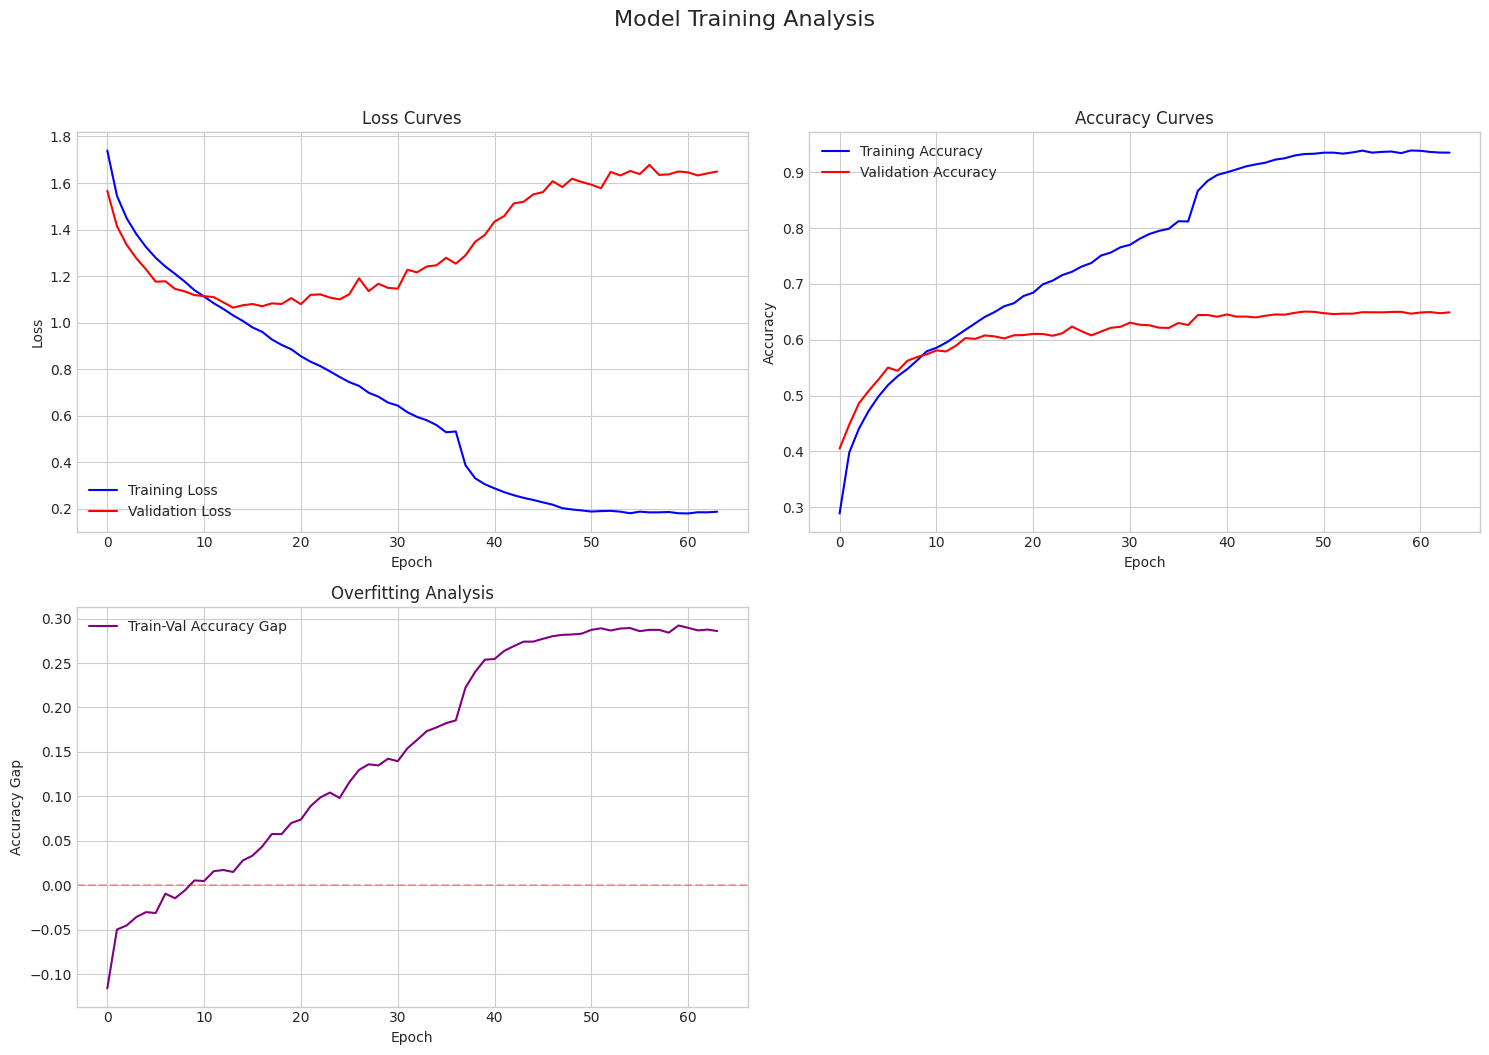

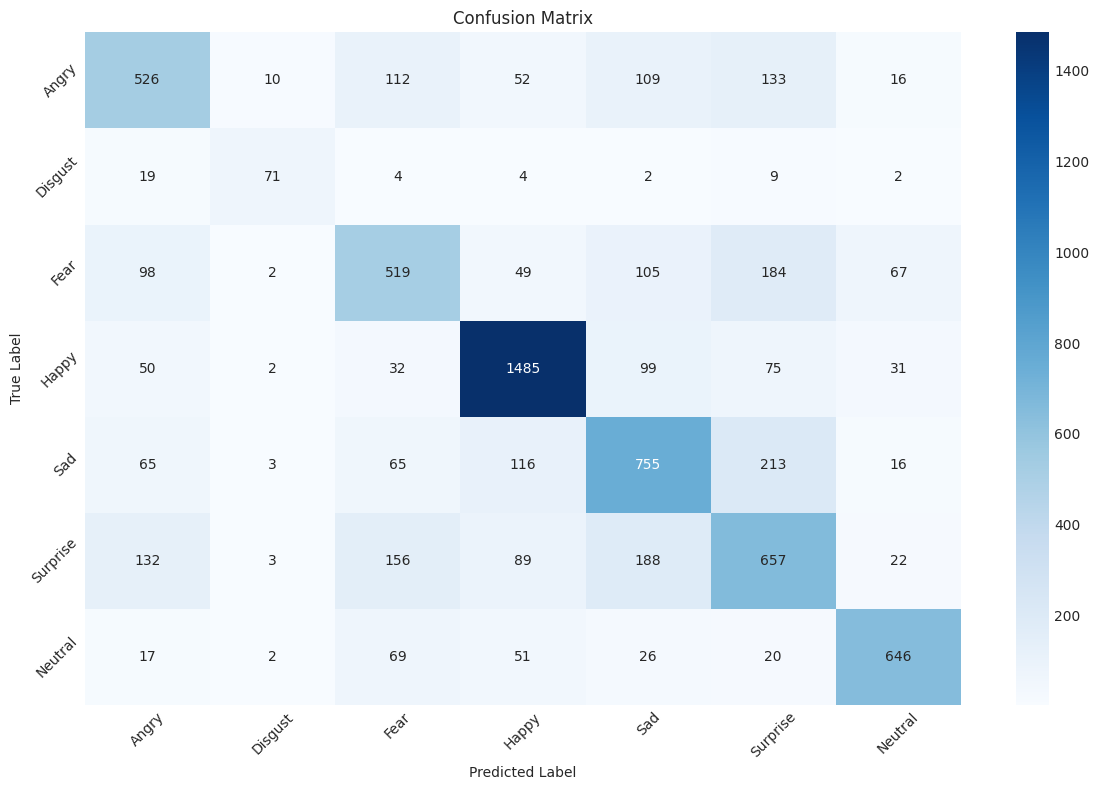


Classification Report:
              precision    recall  f1-score   support

       Angry       0.58      0.55      0.56       958
     Disgust       0.76      0.64      0.70       111
        Fear       0.54      0.51      0.52      1024
       Happy       0.80      0.84      0.82      1774
         Sad       0.59      0.61      0.60      1233
    Surprise       0.51      0.53      0.52      1247
     Neutral       0.81      0.78      0.79       831

    accuracy                           0.65      7178
   macro avg       0.66      0.64      0.64      7178
weighted avg       0.65      0.65      0.65      7178



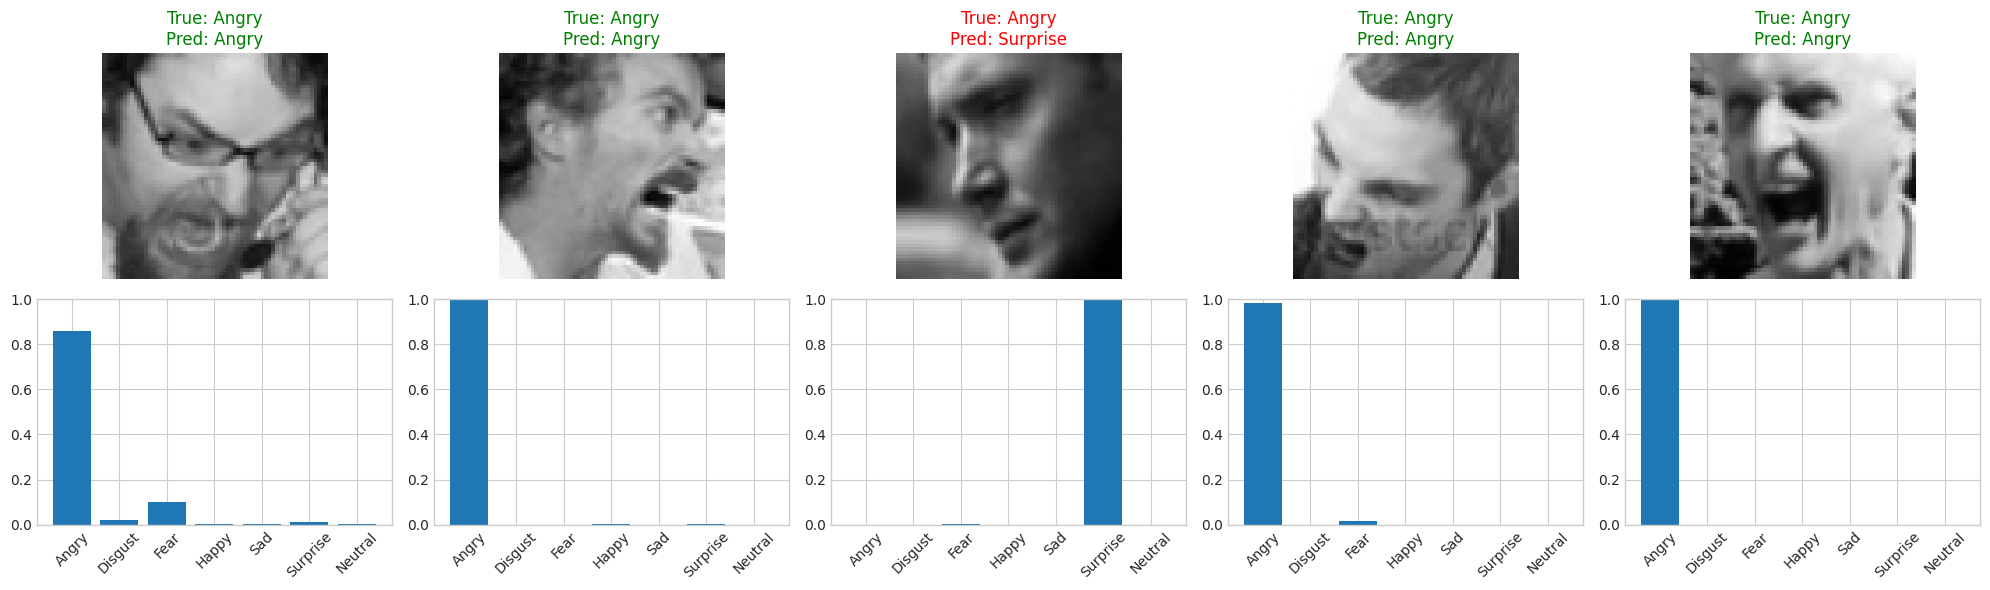

In [3]:
import warnings
warnings.filterwarnings('ignore')

def plot_training_curves(history):
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Training Analysis', fontsize=16, y=1.05)

    # Loss curves
    axes[0,0].plot(history['train_loss'], label='Training Loss', color='blue')
    axes[0,0].plot(history['val_loss'], label='Validation Loss', color='red')
    axes[0,0].set_title('Loss Curves')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Accuracy curves
    axes[0,1].plot(history['train_acc'], label='Training Accuracy', color='blue')
    axes[0,1].plot(history['val_acc'], label='Validation Accuracy', color='red')
    axes[0,1].set_title('Accuracy Curves')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Learning curves (Training vs Validation Gap)
    train_val_gap = np.array(history['train_acc']) - np.array(history['val_acc'])
    axes[1,0].plot(train_val_gap, label='Train-Val Accuracy Gap', color='purple')
    axes[1,0].set_title('Overfitting Analysis')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Accuracy Gap')
    axes[1,0].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Learning Rate if available
    if 'lr' in history:
        axes[1,1].plot(history['lr'], label='Learning Rate', color='green')
        axes[1,1].set_title('Learning Rate Schedule')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Learning Rate')
        axes[1,1].set_yscale('log')
        axes[1,1].legend()
        axes[1,1].grid(True)
    else:
        fig.delaxes(axes[1,1])  # Better way to remove subplot

    plt.tight_layout()
    plt.savefig('training_curves.png', bbox_inches='tight', dpi=300)
    plt.show()

def evaluate_model(model, val_loader, device, class_names):

    model.eval()
    all_preds = []
    all_labels = []
    
    try:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Create confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
    except Exception as e:
        print(f"Error during evaluation: {str(e)}")

def plot_sample_predictions(model, val_loader, device, class_names, num_samples=5):

    model.eval()
    
    try:
        fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
        
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            
            for i in range(min(num_samples, len(inputs))):
                # Plot image
                img = inputs[i].cpu().permute(1, 2, 0)
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
                img = img.clip(0, 1)
                
                axes[0, i].imshow(img)
                axes[0, i].axis('off')
                true_label = class_names[labels[i]]
                pred_label = class_names[outputs[i].argmax()]
                axes[0, i].set_title(f'True: {true_label}\nPred: {pred_label}',
                                   color='green' if true_label == pred_label else 'red')
                
                # Plot probability distribution
                probs = probabilities[i].cpu().numpy()
                axes[1, i].bar(range(len(class_names)), probs)
                axes[1, i].set_xticks(range(len(class_names)))
                axes[1, i].set_xticklabels(class_names, rotation=45)
                axes[1, i].set_ylim(0, 1)
        
        plt.tight_layout()
        plt.savefig('sample_predictions.png', bbox_inches='tight', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error plotting predictions: {str(e)}")

def print_parameter_details(model):
    """
    Print model parameter details and total trainable parameters.
    
    Args:
        model (torch.nn.Module): The model to analyze
    """
    try:
        total_params = 0
        print("\nModel Parameter Details:")
        print("-" * 50)
        for name, parameter in model.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                total_params += params
                print(f"{name:<30} {params:>10,d}")
        print("-" * 50)
        print(f"Total trainable parameters: {total_params:,}")
        
    except Exception as e:
        print(f"Error analyzing parameters: {str(e)}")


print_parameter_details(model)

plot_training_curves(history)

# Definisikan nama kelas sesuai dengan dataset FER2013
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Evaluasi model dan tampilkan confusion matrix
evaluate_model(model, val_loader, device, class_names)

# Tampilkan contoh prediksi
plot_sample_predictions(model, val_loader, device, class_names)